# Set up colab gpu runtime environment

In [1]:
# Uncomment below lines and run this once in your environment to install all the necessary libraries

# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
# Uncomment below line and run this once to donwload the data set 

# !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

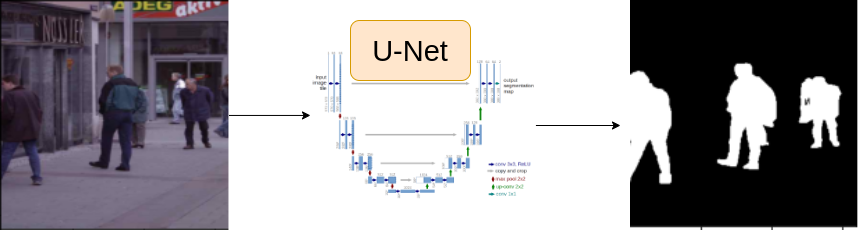

# Some Common Imports

In [3]:
import sys

sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

/media/jhanvi/my_drive/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup Configurations

In [5]:
CSV_FILE ='./Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = './'

DEVICE ='cpu'
EPOCHS = 50
LR = 1e-3
IMG_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

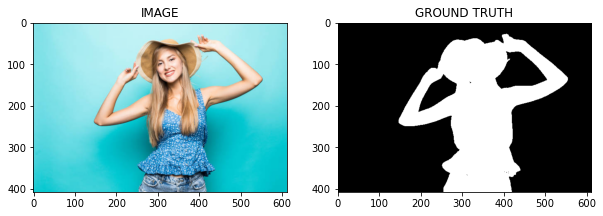

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,valid_df = train_test_split(df, test_size=0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_aug():
    return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
    ])

def get_valid_aug():
    return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
      ])

# Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset 

In [13]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
        mask=  np.expand_dims(mask,axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image , mask = mask)
            image = data['image']
            mask = data['mask']


        image = np.transpose(image, (2,0,1)).astype(np.float64) # (h,w,c) -> (c,h,w)
        mask = np.transpose(mask, (2,0,1)).astype(np.float64)   # (h,w,c) -> (c,h,w)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask



In [14]:
trainset = SegmentationDataset(train_df, get_train_aug())
validset = SegmentationDataset(valid_df, get_valid_aug())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


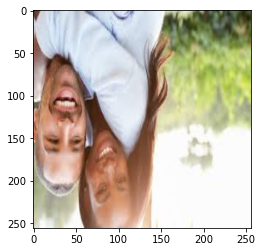

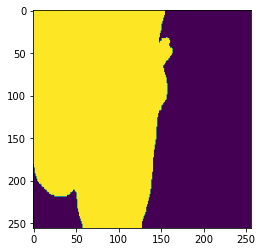

In [16]:
idx = 23
image, mask = trainset[idx]

plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()
plt.imshow(torch.permute(mask, (1, 2, 0)))
plt.show()

# Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle = True)

In [19]:
print('Total number of batches in trainloader : ', len(trainloader))
print('Total number of batches in validloader : ', len(validloader))

Total number of batches in trainloader :  15
Total number of batches in validloader :  4


In [20]:
for image, mask in trainloader:
    break

print('one batch image shape :',image.shape)
print('one batch mask shape :',mask.shape)

one batch image shape : torch.Size([16, 3, 256, 256])
one batch mask shape : torch.Size([16, 1, 256, 256])


#  Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics import accuracy
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc = smp.Unet(
            encoder_name =  ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1, 
            activation = None
        )

    def forward(self,images, masks = None):
        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            tp, fp, fn, tn = smp.metrics.get_stats(logits, masks.int(), mode='binary', threshold=0.5)

            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            return logits, loss1+loss2 , accuracy

        return logits


In [23]:
model = SegmentationModel()
model.to(DEVICE);


# Create Train and Validation Function 

In [24]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    train_acc = 0.0
    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits,loss,acc = model(images,masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_acc += acc
        
    return total_loss / len(data_loader), train_acc/len(data_loader)

In [25]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits,loss, acc = model(images,masks)
            total_loss += loss.item()
            val_acc += acc
                        
    return total_loss/len(data_loader), val_acc/len(data_loader)

# Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loss, train_acc = train_fn(trainloader, model, optimizer)
    valid_loss, val_acc  = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('SAVED-MODEL')
        best_valid_loss = valid_loss

    print(f"Epoch: {i+1} Train Loss : {train_loss} Train Accuracy : {train_acc}  Valid Loss : {valid_loss} Valid accuracy : {val_acc}")

100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


SAVED-MODEL
Epoch: 1 Train Loss : 0.9619706352551778 Train Accuracy : 0.817135214805603  Valid Loss : 0.42042650282382965 Valid accuracy : 0.9367467164993286


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


SAVED-MODEL
Epoch: 2 Train Loss : 0.4424276530742645 Train Accuracy : 0.9380069971084595  Valid Loss : 0.22811557725071907 Valid accuracy : 0.9674736261367798


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


SAVED-MODEL
Epoch: 3 Train Loss : 0.3141365240017573 Train Accuracy : 0.9496735334396362  Valid Loss : 0.17963317036628723 Valid accuracy : 0.9705160856246948


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 4 Train Loss : 0.2604258557160695 Train Accuracy : 0.9560259580612183  Valid Loss : 0.1527811586856842 Valid accuracy : 0.9738628268241882


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch: 5 Train Loss : 0.25987622936566673 Train Accuracy : 0.9537942409515381  Valid Loss : 0.17526976019144058 Valid accuracy : 0.9698997139930725


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 6 Train Loss : 0.23607232371966044 Train Accuracy : 0.9571658372879028  Valid Loss : 0.13794805482029915 Valid accuracy : 0.9771803617477417


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 7 Train Loss : 0.17905422647794086 Train Accuracy : 0.9682331085205078  Valid Loss : 0.11733383312821388 Valid accuracy : 0.9809662699699402


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


SAVED-MODEL
Epoch: 8 Train Loss : 0.18831197867790858 Train Accuracy : 0.9678118824958801  Valid Loss : 0.11573733016848564 Valid accuracy : 0.9781326651573181


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


SAVED-MODEL
Epoch: 9 Train Loss : 0.1558951998750369 Train Accuracy : 0.9727110266685486  Valid Loss : 0.10488491132855415 Valid accuracy : 0.9820989370346069


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch: 10 Train Loss : 0.13441203484932582 Train Accuracy : 0.9759856462478638  Valid Loss : 0.10881071910262108 Valid accuracy : 0.9810814261436462


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 11 Train Loss : 0.1324183871348699 Train Accuracy : 0.9756414890289307  Valid Loss : 0.09079374931752682 Valid accuracy : 0.9848934412002563


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 12 Train Loss : 0.14433798293272654 Train Accuracy : 0.9739020466804504  Valid Loss : 0.08757988177239895 Valid accuracy : 0.9837141633033752


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch: 13 Train Loss : 0.1329542855421702 Train Accuracy : 0.9759500622749329  Valid Loss : 0.09241323918104172 Valid accuracy : 0.9833248257637024


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch: 14 Train Loss : 0.1333761249979337 Train Accuracy : 0.975869357585907  Valid Loss : 0.0877289492636919 Valid accuracy : 0.9846953749656677


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


SAVED-MODEL
Epoch: 15 Train Loss : 0.11204319298267365 Train Accuracy : 0.979323148727417  Valid Loss : 0.0826780553907156 Valid accuracy : 0.9859999418258667


100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


SAVED-MODEL
Epoch: 16 Train Loss : 0.10900137424468995 Train Accuracy : 0.9803647398948669  Valid Loss : 0.07280659675598145 Valid accuracy : 0.9863773584365845


100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


SAVED-MODEL
Epoch: 17 Train Loss : 0.09456798682610194 Train Accuracy : 0.9826928377151489  Valid Loss : 0.06864866334944963 Valid accuracy : 0.9875802993774414


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch: 18 Train Loss : 0.09627747486035029 Train Accuracy : 0.9827224016189575  Valid Loss : 0.06888003647327423 Valid accuracy : 0.986681342124939


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch: 19 Train Loss : 0.1381029561161995 Train Accuracy : 0.9767416715621948  Valid Loss : 0.0817667730152607 Valid accuracy : 0.9860013723373413


100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Epoch: 20 Train Loss : 0.1725898598631223 Train Accuracy : 0.9689868092536926  Valid Loss : 0.11753867380321026 Valid accuracy : 0.9781249165534973


100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 21 Train Loss : 0.1276248594125112 Train Accuracy : 0.9767737984657288  Valid Loss : 0.08800669759511948 Valid accuracy : 0.9845033288002014


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch: 22 Train Loss : 0.12122210264205932 Train Accuracy : 0.9782468676567078  Valid Loss : 0.07763530872762203 Valid accuracy : 0.9863415956497192


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch: 23 Train Loss : 0.1126598005493482 Train Accuracy : 0.9798908829689026  Valid Loss : 0.0724665280431509 Valid accuracy : 0.9865900874137878


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 24 Train Loss : 0.10309936255216598 Train Accuracy : 0.9818278551101685  Valid Loss : 0.06819836050271988 Valid accuracy : 0.9882528185844421


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


SAVED-MODEL
Epoch: 25 Train Loss : 0.11135618338982264 Train Accuracy : 0.9798823595046997  Valid Loss : 0.06640932708978653 Valid accuracy : 0.987403154373169


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch: 26 Train Loss : 0.09655244847138723 Train Accuracy : 0.9822166562080383  Valid Loss : 0.07051006518304348 Valid accuracy : 0.9866078495979309


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


SAVED-MODEL
Epoch: 27 Train Loss : 0.07801361779371897 Train Accuracy : 0.985467791557312  Valid Loss : 0.0627555288374424 Valid accuracy : 0.988137423992157


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch: 28 Train Loss : 0.08207778086264929 Train Accuracy : 0.9848325848579407  Valid Loss : 0.06947407312691212 Valid accuracy : 0.9868730306625366


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


SAVED-MODEL
Epoch: 29 Train Loss : 0.07878482987483343 Train Accuracy : 0.9853191375732422  Valid Loss : 0.05881430767476559 Valid accuracy : 0.9885507822036743


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


SAVED-MODEL
Epoch: 30 Train Loss : 0.07960129876931508 Train Accuracy : 0.985119104385376  Valid Loss : 0.057130634784698486 Valid accuracy : 0.9891512393951416


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch: 31 Train Loss : 0.07520421197017034 Train Accuracy : 0.9857712388038635  Valid Loss : 0.05874201003462076 Valid accuracy : 0.9887605905532837


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


SAVED-MODEL
Epoch: 32 Train Loss : 0.07066581224401793 Train Accuracy : 0.9866713285446167  Valid Loss : 0.05372120440006256 Valid accuracy : 0.989704966545105


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch: 33 Train Loss : 0.06959409266710281 Train Accuracy : 0.9869756698608398  Valid Loss : 0.054746233858168125 Valid accuracy : 0.9898855090141296


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


SAVED-MODEL
Epoch: 34 Train Loss : 0.0734714445968469 Train Accuracy : 0.9863870143890381  Valid Loss : 0.05030561611056328 Valid accuracy : 0.9903967976570129


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 35 Train Loss : 0.06618004937966665 Train Accuracy : 0.987555742263794  Valid Loss : 0.048724524676799774 Valid accuracy : 0.9904789328575134


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch: 36 Train Loss : 0.06869800413648287 Train Accuracy : 0.9871324300765991  Valid Loss : 0.0516221197322011 Valid accuracy : 0.9898286461830139


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch: 37 Train Loss : 0.06819927717248599 Train Accuracy : 0.986958384513855  Valid Loss : 0.04894459433853626 Valid accuracy : 0.9905019998550415


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch: 38 Train Loss : 0.0647238035996755 Train Accuracy : 0.9878578186035156  Valid Loss : 0.04880736768245697 Valid accuracy : 0.9903828501701355


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch: 39 Train Loss : 0.06285496900478998 Train Accuracy : 0.9882838726043701  Valid Loss : 0.050746235996484756 Valid accuracy : 0.989560604095459


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch: 40 Train Loss : 0.06213129485646884 Train Accuracy : 0.9881012439727783  Valid Loss : 0.0488929133862257 Valid accuracy : 0.9907230138778687


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


SAVED-MODEL
Epoch: 41 Train Loss : 0.05951596846183141 Train Accuracy : 0.9885797500610352  Valid Loss : 0.04780869744718075 Valid accuracy : 0.9906738996505737


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch: 42 Train Loss : 0.05897088969747225 Train Accuracy : 0.9886683821678162  Valid Loss : 0.048509822227060795 Valid accuracy : 0.990425169467926


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch: 43 Train Loss : 0.06333677147825559 Train Accuracy : 0.9879154562950134  Valid Loss : 0.05198577605187893 Valid accuracy : 0.9900752305984497


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch: 44 Train Loss : 0.060597117493549985 Train Accuracy : 0.988262414932251  Valid Loss : 0.04852158762514591 Valid accuracy : 0.9907985925674438


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch: 45 Train Loss : 0.05912454028924306 Train Accuracy : 0.9888034462928772  Valid Loss : 0.04923537094146013 Valid accuracy : 0.9903243780136108


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch: 46 Train Loss : 0.05835872491200765 Train Accuracy : 0.9890304207801819  Valid Loss : 0.05144449882209301 Valid accuracy : 0.9893266558647156


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


SAVED-MODEL
Epoch: 47 Train Loss : 0.06355611880620321 Train Accuracy : 0.9878137111663818  Valid Loss : 0.04745026305317879 Valid accuracy : 0.9906584024429321


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


SAVED-MODEL
Epoch: 48 Train Loss : 0.06537308072050413 Train Accuracy : 0.9875971674919128  Valid Loss : 0.04681992810219526 Valid accuracy : 0.990940511226654


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch: 49 Train Loss : 0.06494822452465693 Train Accuracy : 0.9875772595405579  Valid Loss : 0.04734913259744644 Valid accuracy : 0.9906614422798157


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]

Epoch: 50 Train Loss : 0.06141597876946132 Train Accuracy : 0.9882821440696716  Valid Loss : 0.052777430042624474 Valid accuracy : 0.9903802275657654


# Inference

In [28]:
idx = 20
model.load_state_dict(torch.load('./best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (1,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5 ) * 1.0

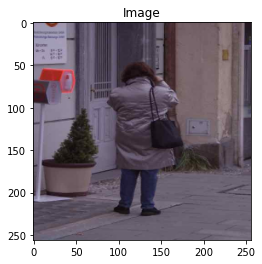

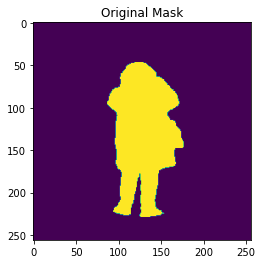

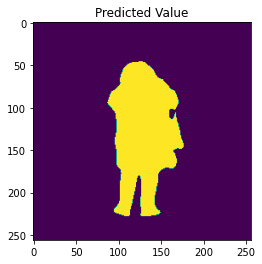

In [29]:

pred_mask = torch.squeeze(pred_mask.detach().cpu(),dim=0)

plt.imshow(image.permute(1,2,0))
plt.title('Image')
plt.show()

plt.imshow(mask.permute(1,2,0))
plt.title('Original Mask')
plt.show()

plt.imshow(pred_mask.permute(1,2,0))
plt.title('Predicted Value')
plt.show()

